# Import packages

In [1]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve
from tqdm import tqdm
import os

# Prepare Dataset

In [2]:
# Load the data with shape: [number of traces, samples per trace, number of center frequencies]
data_full = np.load('dataset/Synthetic.npy')
ntr, ns, nfreq = data_full.shape

# Sampling rate and distance interval
dt = 0.008e-9
dx = 0.004

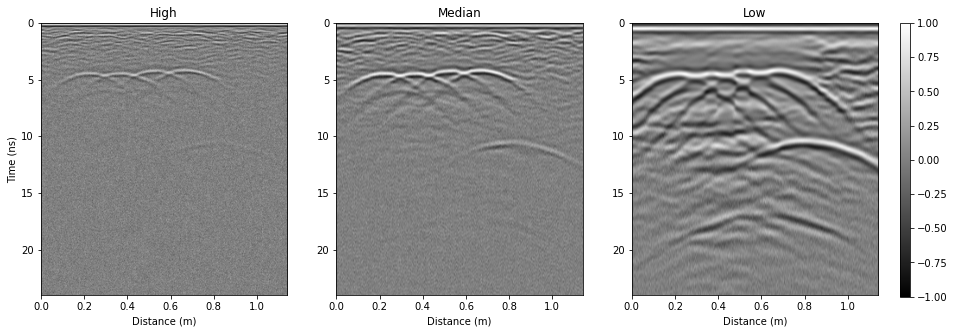

In [3]:
# plot the original B-scan
v_min, v_max = -1, 1
c_map = 'gray'
fig = plt.figure(figsize=[15, 5])

ax1 = plt.subplot(131)
plt.imshow(data_full[:,:,0].T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto', extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('High')
plt.xlabel('Distance (m)')
plt.ylabel('Time (ns)')

ax2 = plt.subplot(132)
plt.imshow(data_full[:,:,1].T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto',  extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('Median')
plt.xlabel('Distance (m)')

ax3 = plt.subplot(133)
h = plt.imshow(data_full[:,:,2].T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto', extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('Low')
plt.xlabel('Distance (m)')

cax = fig.add_axes([0.92, 0.12, 0.01, 0.76])
plt.colorbar(h, cax=cax, orientation='vertical')
plt.show()

In [4]:
# Define thersholds
thershold_high   = [0, 625]
thershold_median = [0, 1450]
thershold_low    = [0, ns]

In [5]:
def calculate_weight(data_full, ns_seg=100, overlap=0.5):
    ntr, ns, nfreq = data_full.shape
    
    # Only the data in the interested time window is considered
    data_used = np.zeros_like(data_full)
    data_used[:, thershold_high[0]:thershold_high[1], 0] = data_full[:, thershold_high[0]:thershold_high[1], 0]
    data_used[:, thershold_median[0]:thershold_median[1], 1] = data_full[:, thershold_median[0]:thershold_median[1], 1]
    data_used[:, thershold_low[0]:thershold_low[1], 2] = data_full[:, thershold_low[0]:thershold_low[1], 2]
    
    # Calculate indicator for each samples
    kernel = np.array([1, -2, 1])
    indicator = np.zeros_like(data_full)
    for ifreq in range(nfreq):
        for itr in range(ntr):
            indicator[itr, :, ifreq] = np.abs(convolve(data_used[itr, :, ifreq], kernel, mode='same'))
    
    # Prepare indices of the sliding window 
    ns_overlap = round(overlap*ns_seg)
    nseg = int(np.fix((ns - ns_overlap)/(ns_seg - ns_overlap)))
    i_start = np.arange(stop=nseg*(ns_seg - ns_overlap), step=ns_seg - ns_overlap)
    i_end = i_start + ns_seg
    if i_end[-1] != ns:
        i_start = np.r_[i_start, ns - ns_seg]
        i_end = np.r_[i_end, ns]
    nseg = len(i_start)
    
    # Calculate the averaged weight
    weight = np.zeros_like(data_full)
    norm_factor = np.zeros_like(data_full)
    for iseg in range(nseg):
        weight[:, i_start[iseg]:i_end[iseg], :] += np.expand_dims(np.sum(indicator[:, i_start[iseg]:i_end[iseg], :], axis=1), axis=1) / ns_seg
        norm_factor[:, i_start[iseg]:i_end[iseg], :] += 1
    weight = weight / norm_factor
    
    # Normalization
    weight = weight / (np.expand_dims(np.sum(weight, axis=2), axis=2))
    
    return weight

In [6]:
# Taking the former few traces for trainning
data_train = data_full[:100, :, :]

# Calculate weight
weight_train = calculate_weight(data_train, ns_seg=100, overlap=0.9)

Text(0, 0.5, 'Normalized weight')

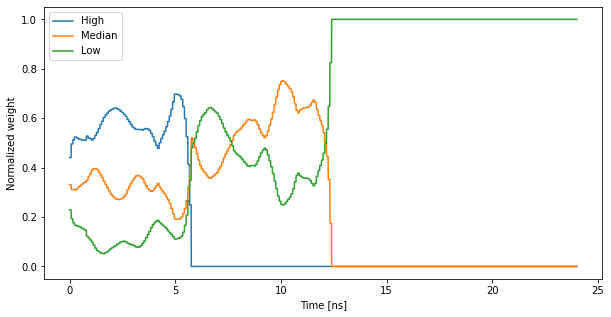

In [7]:
# Check the weight
test_trace = 50
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(ns)*dt*1e9, weight_train[test_trace, :, 0], label='High')
plt.plot(np.arange(ns)*dt*1e9, weight_train[test_trace, :, 1], label='Median')
plt.plot(np.arange(ns)*dt*1e9, weight_train[test_trace, :, 2], label='Low')
ax.legend()
plt.xlabel('Time [ns]')
plt.ylabel('Normalized weight')

# Configurations of neural networks and tranning parameters

In [8]:
# Parameters used in Transformer
d_model = 32
nhead = 2
dim_feedforward = 64
num_layers = 2
max_signal_length = 4096

# Define the model hyperparameters
config = {
    'n_epochs': 50,             # Number of epochs.            
    'batch_size': 16,           # Batch size
    'learning_rate': 1e-3,      # Learning rate
    'save_path': './models/GPRfusionformer_base.ckpt',  # Model will be saved here.
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Neural network

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:,:x.size(1)]

class GPRfusionformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, dim_feedforward, num_layers, max_signal_length):
        super(GPRfusionformer, self).__init__()
        
        self.linear_embedding = nn.Linear(input_size, d_model, bias=False)
        self.positional_encoding = PositionalEncoding(d_model, max_signal_length)
        
        self.encoder_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, 
                                       nhead=nhead, 
                                       dim_feedforward=dim_feedforward, 
                                       batch_first=True, 
                                       norm_first=True), 
            num_layers=num_layers)
        
        self.linear = nn.Linear(d_model, input_size) # Output transformation
        
    def forward(self, x):
        emb = self.positional_encoding(self.linear_embedding(x))
        emb = self.encoder_layers(emb)
        weight = F.softmax(self.linear(emb), dim=-1)
        y = torch.sum(torch.mul(x, weight), dim=-1)
        return y

# Trainer

In [10]:
def trainer(train_loader, model, config, device):
    
    # Define the loss function.
    def loss_fn(y_true, weight, y_pred):
        squared_difference = weight * torch.square((y_true - y_pred.unsqueeze(2)))
        loss_sum = torch.sum(torch.mean(squared_difference, (1, 0)))
        return loss_sum

    # Define optimization algorithm. 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
    
    # Create directory of saving models.
    if not os.path.isdir('./models'):
        os.mkdir('./models') 
    
    def closure():
        optimizer.zero_grad()               # Set gradient to zero
        x = data
        y = weight
        x = x.to(device)                    # Move data to device
        y = y.to(device)
        pred = model(x)             
        loss = loss_fn(x, y, pred)
        loss.backward()                     # Backpropagation
        return loss
    
    
    loss_record = []
    for epoch in range(config['n_epochs']):
        model.train() # Set the model to train mode

        train_pbar = tqdm(train_loader, position=0, leave=True)
        loss_epoch = []
        for data, weight in train_pbar:
            # Update parameters
            loss = optimizer.step(closure=closure)
            
            # Display current epoch number and loss on tqdm progress bar
            train_pbar.set_description(f'Epoch [{epoch+1}/{config["n_epochs"]}]')
            train_pbar.set_postfix({'loss': loss.item()})
            
            loss_epoch.append(loss.item())
            
        loss_record.append(np.mean(loss_epoch))
    
    torch.save(model.state_dict(), config['save_path']) # Save the model
    print('Saving model with loss {:.3f}...'.format(loss_record[-1]))
    
    return loss_record

def predict(test_loader, model, device):
    model.eval() # Set the model to evaluation mode
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# Do training

In [11]:
class GPRfusion_Dataset(Dataset):
    '''
    x: Multifrequency GPR data.
    y: Weight, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [12]:
# Pytorch data loader loads pytorch dataset into batches
train_dataset = GPRfusion_Dataset(data_train, weight_train)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

# Instantiate the model
model = GPRfusionformer(input_size=nfreq, 
                        d_model=d_model, 
                        nhead=nhead, 
                        dim_feedforward=dim_feedforward, 
                        num_layers=num_layers, 
                        max_signal_length=max_signal_length).to(device)

In [13]:
# Training
loss_record = trainer(train_loader, model, config, device)

Epoch [50/50]: 100%|████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s, loss=0.0141]

Saving model with loss 0.013...


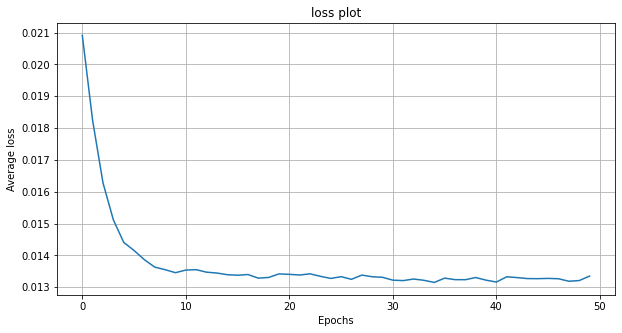

In [14]:
# Plot the loss
plt.figure(figsize=[10, 5])
plt.plot(loss_record)
plt.title('loss plot')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.grid(True)
plt.show()

# Inference

In [15]:
# The whole traces are used in the inference stage
test_dataset = GPRfusion_Dataset(data_full)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
y_pred = predict(test_loader, model, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 27.99it/s]


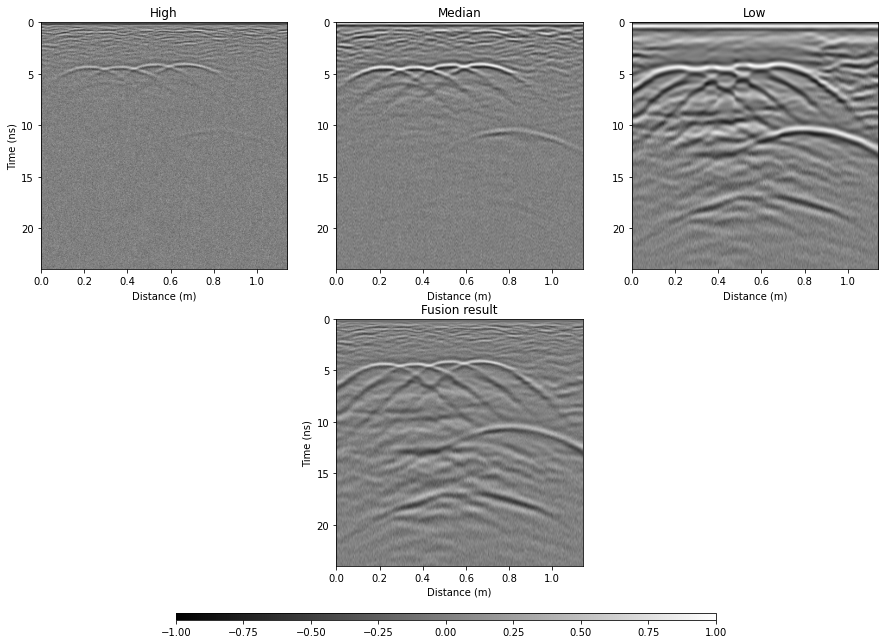

In [16]:
# Show the final fusion result
v_min, v_max = -1, 1
c_map = 'gray'
fig = plt.figure(figsize=[15, 10])

ax1 = plt.subplot(231)
plt.imshow(data_full[:,:,0].T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto', extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('High')
plt.xlabel('Distance (m)')
plt.ylabel('Time (ns)')

ax2 = plt.subplot(232)
plt.imshow(data_full[:,:,1].T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto', extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('Median')
plt.xlabel('Distance (m)')

ax3 = plt.subplot(233)
plt.imshow(data_full[:,:,2].T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto', extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('Low')
plt.xlabel('Distance (m)')

ax4 = plt.subplot(235)
h = plt.imshow(y_pred.T, cmap=c_map, vmin=v_min, vmax=v_max, aspect='auto', extent=[0, (ntr-1)*dx, (ns-1)*dt*1e9, 0])
plt.title('Fusion result')
plt.xlabel('Distance (m)')
plt.ylabel('Time (ns)')

cax = fig.add_axes([0.25, 0.05, 0.5, 0.01])
plt.colorbar(h, cax=cax, orientation='horizontal')
plt.show()